# Create the band_structure.dat using the vasprun.xml file

Information about the k-distance and energies will be obtain from vasprun.xml file. The **band_structure.dat** file is used to plot the custom band structure.

In [2]:
import os
import glob
import logging
import sys
import numpy as np
from pymatgen.io.vasp import Vasprun
from pymatgen.electronic_structure.bandstructure import BandStructureSymmLine, BandStructure, Spin
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, message="No POTCAR file with matching TITEL fields was found")

def find_vasprun():
    "Locate vasprun.xml files in subdirectories starting with 'split-'"
    directories = sorted(glob.glob("split-*")) or ["."]
    vasprun_files = []

    for directory in directories:
        for file_extension in ["vasprun.xml", "vasprun.xml.gz"]:
            vr_file_path = os.path.join(directory, file_extension)
            if os.path.exists(vr_file_path):
                vasprun_files.append(vr_file_path)
                break 

    return vasprun_files

def calculate_k_distance(kpoints):
    "Calculate the k-distance from the k-points"
    distances = [0.0]
    for i in range(1, len(kpoints)):
        dist = np.linalg.norm(kpoints[i].frac_coords - kpoints[i-1].frac_coords)
        distances.append(distances[-1] + dist)
    return distances

def save_data(bs, prefix=None, directory=None):
    "Save band structure data"
    output_filename = os.path.join(directory or ".", "band_structure.dat")
    reference_energy = bs.efermi if bs.is_metal() else bs.get_vbm()["energy"]

    with open(output_filename, "w") as output_file:
        output_file.write("#k-distance eigenvalues(eV)\n")

        k_distances = calculate_k_distance(bs.kpoints)

        # Extract and write eigenvalues for both spin-up and spin-down bands
        for spin in [Spin.up, Spin.down] if bs.is_spin_polarized else [Spin.up]:
            for band in bs.bands[spin]:
                for distance, energy in zip(k_distances, band):
                    output_file.write(f"{distance:.8f} {energy - reference_energy:.8f}\n")
                output_file.write("\n")

    return output_filename

def main():

    # Find vasprun.xml files
    vasprun_files = find_vasprun()
    
    for vr_file in vasprun_files:
        # Parse the vasprun.xml file to get band structure
        try:
            vasprun = Vasprun(vr_file)
            bs = vasprun.get_band_structure()

            # Save the data
            save_data(bs, prefix=os.path.basename(vr_file).split('.')[0], directory='.')

        except Exception as e:
            logging.error(f"ERROR processing {vr_file}: {str(e)}")

    print("Data has been saved.")

if __name__ == "__main__":
    main()

Data has been saved.


# Plot the band structure

Plot the band structure using the **band_structure.dat** file, which it was obtained from the above code.

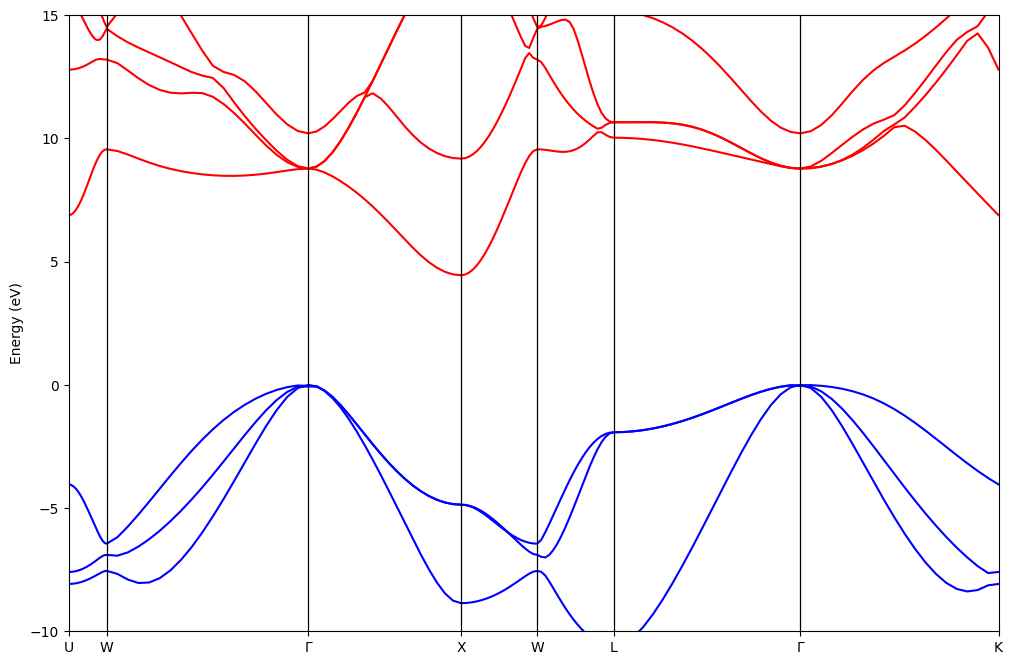

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# load file
data = np.loadtxt("band_structure.dat")

# Create figure
fig, ax = plt.subplots()

# Detect changes that indicate block separation
is_block_start = np.concatenate(([True], np.diff(data[:, 0]) < 0))
block_indices = np.where(is_block_start)[0]

# plot the blocks
for i in range(len(block_indices)):
    if i < len(block_indices) - 1:
        block_data = data[block_indices[i]:block_indices[i + 1]]
    else:
        block_data = data[block_indices[i]:]  # Último bloque

    # Separate the VBM and CBM, VBM below 0 and CBM above 0 
    valence_band = block_data[block_data[:, 1] < 0]
    conduction_band = block_data[block_data[:, 1] > 0]

    # plot VBM and CBM with different colors 
    if len(valence_band) > 0:
        ax.plot(valence_band[:, 0], valence_band[:, 1], linestyle='-', markersize=1, c='blue')#, label='Valencia' if 'Valencia' not in ax.get_legend_handles_labels()[1] else "")
    
    if len(conduction_band) > 0:
        ax.plot(conduction_band[:, 0], conduction_band[:, 1], linestyle='-', markersize=1, c='red')#, label='Conducción' if 'Conducción' not in ax.get_legend_handles_labels()[1] else "")


ax.set_ylabel('Energy (eV)')
# ax.set_xlim(0.0, 1.9395681)
#ax.axhline(y=4.4500, color='k', linestyle='dashed')
#ax.axhline(y=0, color='k', linestyle='dashed')

k_path = [0.0, 0.17677670, 1.11219104, 1.81929782, 2.17285121, 2.52640460, 3.39243001, 4.31098866]

for x in k_path[1:-1]:
    ax.axvline(x=x, color='k', linestyle='-', linewidth=0.9)

plt.ylim(-10,15)
plt.xlim(0,4.31098866)
fig.set_size_inches(12, 8)
ax.set_xticks(k_path)
ax.set_xticklabels(['U','W','$\\Gamma$', 'X', 'W', 'L', '$\\Gamma$', 'K'])
#plt.legend(markerscale=5)
plt.show()